# Quarterback Passing Yards/Game Predictive Modeling

## Importing Passer Data

In [2]:
# Import dependencies
# NFL pbp data
import nfl_data_py as nfl

# Basics / visualizations
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Machine learning tools
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

# Stats Stuff
from scipy import stats
from scipy.stats import skew
import statsmodels.api as sm


# Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)


In [3]:
schedule = nfl.import_schedules([2024])

In [83]:
# Select only the relevant columns
columns = ['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards', 
           'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
           'passing_yards', 'cpoe', 'roof', 'surface']

# Loading in the NFL pbp data
data = nfl.import_pbp_data(range(2014,2025), columns, include_participation=False)

# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
data = data[columns]

# Drop all rows that are not a pass
data = data[data['play_type'] == 'pass']

# Drop the play type column
passer_data = data.drop(columns=['play_type'])

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


In [84]:
passer_data

,game_id,passer_player_name,posteam,defteam,season,week,home_team,away_team,air_yards,yards_after_catch,epa,complete_pass,incomplete_pass,interception,qb_hit,sack,pass_touchdown,passing_yards,cpoe,roof,surface
4,2014_01_BUF_CHI,E.Manuel,BUF,CHI,2014,1,CHI,BUF,11.0,NaN,-1.542538,0.0,1.0,0.0,0.0,0.0,0.0,NaN,-63.542004,outdoors,grass
7,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,CHI,BUF,4.0,4.0,0.889353,1.0,0.0,0.0,0.0,0.0,0.0,8.0,24.549454,outdoors,grass
8,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,CHI,BUF,39.0,5.0,2.468265,1.0,0.0,0.0,0.0,0.0,0.0,44.0,71.269318,outdoors,grass
9,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,CHI,BUF,12.0,0.0,1.879388,1.0,0.0,0.0,0.0,0.0,1.0,12.0,53.646080,outdoors,grass
12,2014_01_BUF_CHI,E.Manuel,BUF,CHI,2014,1,CHI,BUF,1.0,11.0,0.731470,1.0,0.0,0.0,0.0,0.0,0.0,12.0,19.861258,outdoors,grass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489921,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,CIN,WAS,-1.0,1.0,-0.272676,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.075715,outdoors,
489922,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,CIN,WAS,13.0,0.0,0.936383,1.0,0.0,0.0,0.0,0.0,0.0,13.0,37.446724,outdoors,
489924,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,CIN,WAS,29.0,NaN,-0.228033,0.0,1.0,0.0,0.0,0.0,0.0,NaN,-31.641153,outdoors,
489925,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,CIN,WAS,13.0,0.0,1.426387,1.0,0.0,0.0,0.0,0.0,0.0,13.0,38.319050,outdoors,


## Passer Preprocessing & Feature Engineering

In [85]:
# Group the data together by passer, week, season and aggregate
passer_df = passer_data.groupby(['game_id', 'passer_player_name', 'week', 'season'], as_index=False).agg(
    {'posteam' : 'first',
     'defteam' : 'first',
     'home_team' : 'first',
     'away_team' : 'first',
     'air_yards' : 'sum',
     'yards_after_catch' : 'sum',
     'epa' : 'sum',
     'complete_pass' : 'sum',
     'incomplete_pass' : 'sum',
     'interception' : 'sum',
     'qb_hit' : 'sum',
     'sack' : 'sum',
     'pass_touchdown' : 'sum',
     'passing_yards' : 'sum',
     'cpoe' : 'mean',
     'roof' : 'first',
     'surface' : 'first'
     }
)

In [86]:
# Create a new column that is completion percentage
passer_df['completion_percentage'] = passer_df['complete_pass'] / (passer_df['complete_pass'] + passer_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
passer_df['pass_attempts'] = passer_df['complete_pass'] + passer_df['incomplete_pass']

# Drop the complete_pass and incomplete_pass columns
passer_df = passer_df.drop(columns=['complete_pass', 'incomplete_pass'])

In [87]:
# Create a new column that equals 1 if the passer is the home team and 0 if the passer is the away team
passer_df['home_flag'] = passer_df['home_team'] == passer_df['posteam']

# Drop the home_team and away_team columns
passer_df = passer_df.drop(columns=['home_team', 'away_team'])

In [88]:
# Reorder the columns
passer_df = passer_df[['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'passing_yards', 'home_flag', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                        'cpoe', 'roof', 'surface']]

In [89]:
# Calculate the exponentially weighted moving average for each feature
passer_df['completion_percentage_ewma'] = passer_df.groupby('passer_player_name')['completion_percentage']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['pass_attempts_ewma'] = passer_df.groupby('passer_player_name')['pass_attempts']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['air_yards_ewma'] = passer_df.groupby('passer_player_name')['air_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['yards_after_catch_ewma'] = passer_df.groupby('passer_player_name')['yards_after_catch']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['epa_ewma'] = passer_df.groupby('passer_player_name')['epa']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['interception_ewma'] = passer_df.groupby('passer_player_name')['interception']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['qb_hit_ewma'] = passer_df.groupby('passer_player_name')['qb_hit']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['sack_ewma'] = passer_df.groupby('passer_player_name')['sack']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['pass_touchdown_ewma'] = passer_df.groupby('passer_player_name')['pass_touchdown']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['passing_yards_ewma'] = passer_df.groupby('passer_player_name')['passing_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['cpoe_ewma'] = passer_df.groupby('passer_player_name')['cpoe']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

In [90]:
# Drop the non-ewma columns
passer_df = passer_df.drop(columns=['completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'cpoe'])

## Defense Preprocessing & Feature Engineering

In [91]:
# Select only the relevant columns
defense_columns = ['defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards',
                   'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
                   'passing_yards', 'cpoe', 'roof', 'surface']


# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
defense_data = data[defense_columns]

# Drop the play type column
defense_data = defense_data.drop(columns=['play_type'])

In [92]:
# Group the data together by passer, week, season and aggregate
defense_df = defense_data.groupby(['defteam', 'week', 'season'], as_index=False).agg(
    {'home_team': 'first',
     'away_team': 'first',
     'air_yards': 'sum',
     'yards_after_catch': 'sum',
     'epa': 'sum',
     'complete_pass': 'sum',
     'incomplete_pass': 'sum',
     'interception': 'sum',
     'qb_hit': 'sum',
     'sack': 'sum',
     'pass_touchdown': 'sum',
     'passing_yards': 'sum',
     'cpoe': 'mean',
     'roof': 'first',
     'surface': 'first'
     }
)

In [93]:
# Create a new column that is completion percentage
defense_df['completion_percentage'] = defense_df['complete_pass'] / (defense_df['complete_pass'] + defense_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
defense_df['pass_attempts'] = defense_df['complete_pass'] + defense_df['incomplete_pass']

# Drop the complete_pass and incomplete_pass columns
defense_df = defense_df.drop(columns=['complete_pass', 'incomplete_pass'])

In [94]:
# Create a new column that equals 1 if the defense is the home team and 0 if the defense is the away team
defense_df['home_flag'] = defense_df['home_team'] == defense_df['defteam']

# Drop the home_team and away_team columns
defense_df = defense_df.drop(columns=['home_team', 'away_team'])

In [95]:
# Reorder the columns
defense_df = defense_df[['defteam', 'season', 'week', 'home_flag', 'passing_yards', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                       'cpoe', 'roof', 'surface']]

In [96]:
# Calculate the exponentially weighted moving average for each feature
defense_df['completion_percentage_ewma'] = defense_df.groupby('defteam')['completion_percentage']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['pass_attempts_ewma'] = defense_df.groupby('defteam')['pass_attempts']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['air_yards_ewma'] = defense_df.groupby('defteam')['air_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['yards_after_catch_ewma'] = defense_df.groupby('defteam')['yards_after_catch']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['epa_ewma'] = defense_df.groupby('defteam')['epa']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['interception_ewma'] = defense_df.groupby('defteam')['interception']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['qb_hit_ewma'] = defense_df.groupby('defteam')['qb_hit']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['sack_ewma'] = defense_df.groupby('defteam')['sack']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['pass_touchdown_ewma'] = defense_df.groupby('defteam')['pass_touchdown']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['passing_yards_ewma'] = defense_df.groupby('defteam')['passing_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['cpoe_ewma'] = defense_df.groupby('defteam')['cpoe']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

In [97]:
# Drop the non-ewma columns
defense_df = defense_df.drop(columns=['passing_yards','completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'pass_attempts', 'cpoe'])

## Merging Passer & Defense Data

In [98]:
# Merge the defense and passer dataframes together
full_with_ewma = passer_df.merge(defense_df, how='inner', on=['defteam', 'season', 'week', 'roof', 'surface'], suffixes=('_passer', '_defense'))
# Get rid of flukey rows. Jury out on Taysom Hill I guess.
filtered_with_ewma = full_with_ewma[(full_with_ewma['pass_attempts'] > 8)]

filtered_with_ewma

,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag_passer,pass_attempts,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
0,2014_01_BUF_CHI,E.Manuel,BUF,CHI,2014,1,173.0,False,21.0,outdoors,grass,0.761905,21.000000,190.000000,80.000000,0.368607,1.000000,3.000000,1.000000,1.000000,173.000000,11.150598,True,0.761905,21.000000,190.000000,80.000000,0.368607,1.000000,3.000000,1.000000,1.000000,173.000000,11.150598
1,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,349.0,True,47.0,outdoors,grass,0.723404,47.000000,366.000000,190.000000,-6.755498,2.000000,4.000000,2.000000,2.000000,349.000000,2.864331,False,0.723404,47.000000,366.000000,190.000000,-6.755498,2.000000,4.000000,2.000000,2.000000,349.000000,2.864331
2,2014_01_CAR_TB,D.Anderson,CAR,TB,2014,1,230.0,False,33.0,outdoors,grass,0.727273,33.000000,242.000000,70.000000,8.423189,0.000000,3.000000,1.000000,2.000000,230.000000,9.822589,True,0.727273,33.000000,242.000000,70.000000,8.423189,0.000000,3.000000,1.000000,2.000000,230.000000,9.822589
3,2014_01_CAR_TB,J.McCown,TB,CAR,2014,1,183.0,True,33.0,outdoors,grass,0.666667,33.000000,245.000000,45.000000,-10.437736,2.000000,9.000000,3.000000,2.000000,183.000000,0.519191,False,0.666667,33.000000,245.000000,45.000000,-10.437736,2.000000,9.000000,3.000000,2.000000,183.000000,0.519191
4,2014_01_CIN_BAL,A.Dalton,CIN,BAL,2014,1,301.0,False,38.0,outdoors,sportturf,0.657895,38.000000,262.000000,172.000000,11.252419,0.000000,1.000000,0.000000,1.000000,301.000000,-2.044219,True,0.657895,38.000000,262.000000,172.000000,11.252419,0.000000,1.000000,0.000000,1.000000,301.000000,-2.044219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6748,2024_03_PHI_NO,J.Hurts,PHI,NO,2024,3,311.0,False,37.0,dome,sportturf,0.771150,34.502832,241.430646,161.594642,-2.350847,1.049550,6.304153,3.128736,0.404279,276.028508,9.806723,True,0.695370,37.702864,320.912077,165.116990,-4.428504,0.963885,6.015722,3.172964,0.356015,288.028137,3.377774
6749,2024_03_SF_LA,B.Purdy,SF,LA,2024,3,292.0,False,30.0,dome,matrixturf,0.738309,31.253286,319.248695,57.281068,10.390618,0.231710,4.058320,2.192788,2.260245,292.181912,7.473561,True,0.685915,36.503721,334.530816,77.909885,8.116501,0.233649,3.678584,1.377913,2.063135,289.603465,2.527158
6750,2024_03_SF_LA,M.Stafford,LA,SF,2024,3,221.0,True,25.0,dome,matrixturf,0.661731,27.515754,243.125736,98.034767,0.608555,0.090585,6.395725,3.347680,0.807042,231.750317,3.032181,False,0.633160,28.028805,272.863258,77.761778,-0.983938,0.233339,5.455731,2.789464,0.725497,200.224847,1.121569
6752,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,324.0,True,38.0,outdoors,,0.729274,36.380665,257.093181,115.619849,10.899412,0.016883,4.420252,2.311366,2.494750,292.143028,7.180779,False,0.726086,36.228201,298.165731,112.622051,13.486049,0.225780,3.555400,1.585342,2.570251,300.739734,6.179144


## Removing Outliers

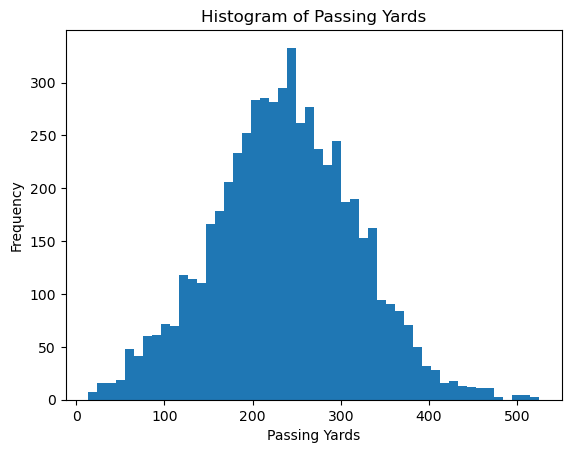

In [99]:
# Identify distribution shape to recreate after we get model results. This looks normal so using our projection for each QB for a week we will use RMSE
# as the standard deviation to create a normal distribution and assign a likelihood to each 
plt.hist(filtered_with_ewma['passing_yards'], bins=50)  # You can adjust the number of bins
plt.xlabel('Passing Yards')
plt.ylabel('Frequency')
plt.title('Histogram of Passing Yards')
plt.show()

## Exploratory Data Analysis

In [100]:
# Get an overview of the data
filtered_with_ewma.describe().round(2)

,season,week,passing_yards,pass_attempts,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
count,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00
mean,2018.68,9.51,236.79,32.16,0.66,31.83,264.05,108.46,0.90,0.75,5.05,2.22,1.46,234.67,0.19,0.66,33.75,280.63,114.52,0.55,0.83,5.41,2.39,1.53,247.68,0.22
std,2.95,5.44,81.26,9.17,0.08,7.51,79.37,36.97,8.03,0.65,2.17,1.27,0.89,66.64,7.01,0.07,5.83,69.62,31.45,7.99,0.68,2.03,1.26,0.82,53.63,6.24
min,2014.00,1.00,14.00,9.00,0.22,6.89,15.00,5.80,-29.73,0.00,0.00,0.00,0.00,22.00,-39.47,0.36,13.93,91.69,31.91,-27.07,0.00,0.00,0.00,0.00,81.57,-28.19
25%,2016.00,5.00,183.00,26.00,0.61,27.23,210.33,83.29,-4.45,0.23,3.49,1.26,0.82,192.20,-4.07,0.61,29.69,231.55,92.29,-4.66,0.25,3.97,1.47,0.92,209.60,-3.79
50%,2019.00,10.00,236.00,32.00,0.66,32.07,260.96,106.76,0.73,0.69,4.83,2.05,1.37,235.58,0.46,0.66,33.49,275.61,111.19,0.85,0.73,5.21,2.24,1.47,245.15,0.30
75%,2021.00,14.00,291.00,38.00,0.71,36.75,314.78,132.32,6.41,1.11,6.39,2.95,2.00,279.99,4.91,0.70,37.47,323.81,134.08,6.04,1.22,6.68,3.13,2.05,283.49,4.47
max,2024.00,22.00,525.00,67.00,1.00,61.00,603.72,250.26,26.29,4.15,14.94,8.25,5.52,483.02,23.10,0.89,61.00,627.07,244.09,27.12,4.01,14.39,8.42,4.96,458.00,20.70


## Modeling w/ Sci-kit Learn

maybe come back to the below cell and figure out how to transform these features into numerical values

In [101]:
# Define the target and features
target = 'passing_yards'
features = filtered_with_ewma.columns.drop(['pass_attempts', 'passer_player_name', 'passing_yards', 'posteam', 'defteam', 'season', 'week', 'game_id'])

In [102]:
# #running on everything to get best params, once I get params take them adn make new model holding out 
# X = filtered_with_ewma.loc[filtered_with_ewma['season'] != 2024, features]
# y = filtered_with_ewma.loc[filtered_with_ewma['season'] != 2024, target]

# # Select columns for one-hot encoding and standard scaling
# categorical_columns = ['roof', 'surface']
# numeric_columns = [item for item in X.columns if item not in ['roof', 'surface']]

# # Create a column transformer for preprocessing (OHE for categorical, SS for numeric)
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(), categorical_columns),
#         ('num', StandardScaler(), numeric_columns)
#     ])

# # Define the parameter grid for tuning
# param_grid = {
#     'num_leaves': [10, 20, 30, 40, 50],
#     'learning_rate': [0.01, 0.03, 0.05, 0.1],
#     'max_depth': [-1, 5, 10, 15],
#     'min_data_in_leaf': [10, 20, 30, 50, 100],
#     'min_split_gain': [0.0, 0.1, 0.2],
#     'subsample_for_bin': [20000, 30000, 40000],
#     'subsample': [0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'bagging_fraction': [0.7, 0.8, 0.9],
#     'feature_fraction': [0.7, 0.8, 0.9],
#     'lambda_l1': [0, 0.1, 0.5, 1],
#     'lambda_l2': [0, 0.1, 0.5, 1],
#     'scale_pos_weight': [1, 10, 20],  # for imbalanced datasets
#     'objective': ['regression'],
#     'boosting_type': ['gbdt', 'dart', 'goss'],  # try different boosting types
#     'n_estimators': [500, 1000, 1500],
#     'metric': ['rmse']
# }

# # Instantiate the LGBM model
# model = lgb.LGBMRegressor(boosting_type='gbdt', random_state=42)

# # Define the pipeline with preprocessing and the model
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', model)
# ])

# # Set up Bayesian Search using the pipeline
# opt = BayesSearchCV(
#     estimator=pipeline,  # Use the pipeline in Bayesian optimization
#     search_spaces={'regressor__' + k: v for k, v in param_grid.items()},  # Prefix params with 'regressor__'
#     n_iter=50,  # Number of iterations for Bayesian optimization
#     cv=3,
#     random_state=42,
#     verbose=1,
#     n_jobs=-1  # Use parallel processing
# )

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Fit the Bayesian optimization search
# opt.fit(X_train, y_train)

# # Get the best parameters
# best_params = opt.best_params_

# # Save best parameters as a dictionary (without 'regressor__' prefix)
# cleaned_best_params = {k.replace('regressor__', ''): v for k, v in best_params.items()}

In [103]:
# Define the best parameters from Bayesian optimization
best_params = {
    'bagging_fraction': 0.7,
    'boosting_type': 'goss',
    'colsample_bytree': 0.9,
    'feature_fraction': 0.8,
    'lambda_l1': 1,
    'lambda_l2': 0,
    'learning_rate': 0.01,
    'max_depth': 5,
    'metric': 'rmse',
    'min_data_in_leaf': 10,
    'min_split_gain': 0.2,
    'n_estimators': 1000,
    'num_leaves': 10,
    'objective': 'regression',
    'scale_pos_weight': 10,
    'subsample': 0.9,
    'subsample_for_bin': 30000
}


In [104]:
# Use data for all seasons before 2023 for training
X = filtered_with_ewma.loc[filtered_with_ewma['season'] <= 2023, features]
y = filtered_with_ewma.loc[filtered_with_ewma['season'] <= 2023, target]

In [105]:
# The data for 2024 that we will hold out for final testing
X_2024 = filtered_with_ewma.loc[filtered_with_ewma['season'] == 2024, features]
y_2024 = filtered_with_ewma.loc[filtered_with_ewma['season'] == 2024, target]

In [106]:
# Ensure there are no missing values in X or y
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Select columns for one-hot encoding and standard scaling
categorical_columns = ['roof', 'surface']
numeric_columns = [item for item in X.columns if item not in ['roof', 'surface']]

# Create a column transformer for preprocessing (OHE for categorical, SS for numeric)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ])

# Instantiate the LGBM model with the best parameters
model = lgb.LGBMRegressor(**best_params, random_state=42, verbosity=-1)

# Define the pipeline with preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Fit the model to all the data through 2023
pipeline.fit(X, y)

# Evaluate the model on the 2024 data
y_pred_2024 = pipeline.predict(X_2024)

# Print results (e.g., performance metrics)
print(f"2024 set performance: RMSE = {mean_squared_error(y_2024, y_pred_2024, squared=False)}")

2024 set performance: RMSE = 19.123255015755912


In [107]:
# Adding identifier columns back after filtering for 2024 data
X_2024 = filtered_with_ewma.loc[filtered_with_ewma['season'] == 2024, features]
X_2024 = X_2024.merge(filtered_with_ewma[['game_id', 'passer_player_name', 'posteam', 'week']], left_index=True, right_index=True)

In [108]:
# Assuming you have a column like 'game_id' that identifies each game
game_id_column = 'game_id'
passer_column = 'passer_player_name'
team_column = 'posteam'
week_column = 'week'

# Preprocess the 2024 data using the pipeline (no need to use 'preprocessor' step directly)
y_pred_2024 = pipeline.predict(X_2024)

# Create a DataFrame to store predictions along with the game identifier
pred_df = pd.DataFrame({
    game_id_column: X_2024[game_id_column].values,
    passer_column: X_2024[passer_column].values,            # Passer name (QB)
    team_column: X_2024[team_column].values,  # Get the game IDs from X_2024
    week_column: X_2024[week_column].values,  #Week
    'true_passing_yards': y_2024.values,                     # Actual target values
    'predicted_passing_yards': y_pred_2024                   # Predicted values
})

pred_df['pass_yards_oe'] = pred_df['true_passing_yards'] - pred_df['predicted_passing_yards']

In [109]:
pred_df.sort_values('pass_yards_oe', ascending = False)

,game_id,passer_player_name,posteam,week,true_passing_yards,predicted_passing_yards,pass_yards_oe
92,2024_03_NYG_CLE,D.Jones,NYG,3,236.0,193.225352,42.774648
90,2024_03_NE_NYJ,A.Rodgers,NYJ,3,281.0,239.993807,41.006193
67,2024_03_CAR_LV,A.Dalton,CAR,3,319.0,280.241614,38.758386
24,2024_01_NYJ_SF,A.Rodgers,NYJ,1,167.0,130.451047,36.548953
71,2024_03_CHI_IND,C.Williams,CHI,3,363.0,328.505959,34.494041
...,...,...,...,...,...,...,...
78,2024_03_HOU_MIN,C.Stroud,HOU,3,215.0,251.853971,-36.853971
69,2024_03_CAR_LV,G.Minshew,LV,3,214.0,251.794327,-37.794327
63,2024_02_TB_DET,B.Mayfield,TB,2,185.0,225.122614,-40.122614
68,2024_03_CAR_LV,A.O'Connell,LV,3,82.0,125.826550,-43.826550


In [110]:
pred_df.shape

(100, 7)

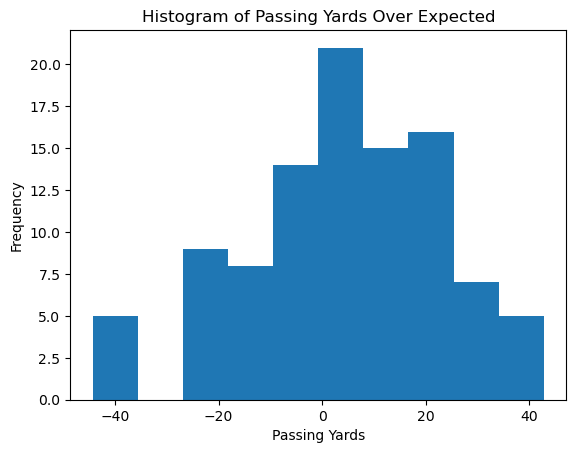

In [121]:
plt.hist(pred_df['pass_yards_oe'], bins=10)  # You can adjust the number of bins
plt.xlabel('Passing Yards')
plt.ylabel('Frequency')
plt.title('Histogram of Passing Yards Over Expected')
plt.show()

#Chat GPT convo on boostrapping for distribution- use it!
#also- make sure we setup the span on EWMA's to be max(whateverbasedf['week']) to get proper span number that will increase with week. long term need to find a way to rerun weekly but that is so far away still lol

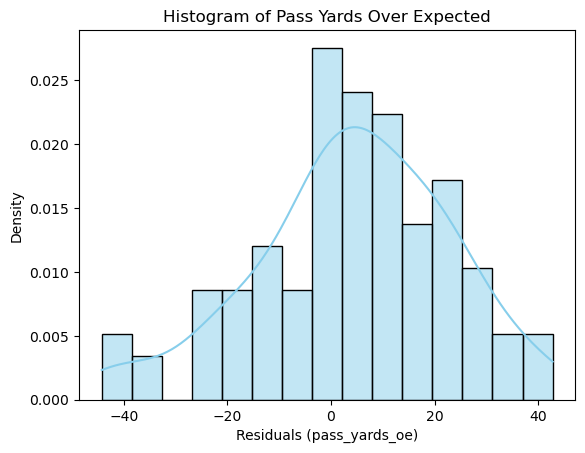

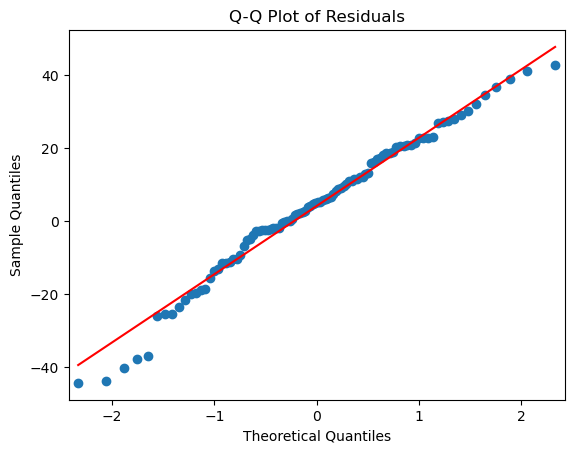

In [122]:
# Assuming 'residuals' is your numpy array of pass_yards_oe
residuals = pred_df['pass_yards_oe'].values

# Histogram and KDE
sns.histplot(residuals, bins=15, kde=True, stat='density', color='skyblue')
plt.title('Histogram of Pass Yards Over Expected')
plt.xlabel('Residuals (pass_yards_oe)')
plt.ylabel('Density')
plt.show()

# Q-Q Plot
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [123]:
# Fit Normal Distribution
mu_norm, sigma_norm = stats.norm.fit(residuals)

# Fit Student's t-Distribution
df_t, loc_t, scale_t = stats.t.fit(residuals)

# Fit Skew-Normal Distribution
shape_skew, loc_skew, scale_skew = stats.skewnorm.fit(residuals)

# Fit Laplace Distribution
loc_laplace, scale_laplace = stats.laplace.fit(residuals)

In [124]:
def calculate_aic(n_params, log_likelihood):
    return 2 * n_params - 2 * log_likelihood

def calculate_bic(n_params, log_likelihood, n_samples):
    return np.log(n_samples) * n_params - 2 * log_likelihood

n = len(residuals)

# Normal Distribution
loglik_norm = np.sum(stats.norm.logpdf(residuals, mu_norm, sigma_norm))
aic_norm = calculate_aic(2, loglik_norm)
bic_norm = calculate_bic(2, loglik_norm, n)

# t-Distribution
loglik_t = np.sum(stats.t.logpdf(residuals, df_t, loc_t, scale_t))
aic_t = calculate_aic(3, loglik_t)
bic_t = calculate_bic(3, loglik_t, n)

# Skew-Normal Distribution
loglik_skew = np.sum(stats.skewnorm.logpdf(residuals, shape_skew, loc_skew, scale_skew))
aic_skew = calculate_aic(3, loglik_skew)
bic_skew = calculate_bic(3, loglik_skew, n)

# Laplace Distribution
loglik_laplace = np.sum(stats.laplace.logpdf(residuals, loc_laplace, scale_laplace))
aic_laplace = calculate_aic(2, loglik_laplace)
bic_laplace = calculate_bic(2, loglik_laplace, n)

# Compare AIC and BIC
print('AIC Values:')
print(f'Normal: {aic_norm}, t-Distribution: {aic_t}, Skew-Normal: {aic_skew}, Laplace: {aic_laplace}')

print('BIC Values:')
print(f'Normal: {bic_norm}, t-Distribution: {bic_t}, Skew-Normal: {bic_skew}, Laplace: {bic_laplace}')

#lower is better for both

AIC Values:
Normal: 873.2024419434562, t-Distribution: 875.1796351941654, Skew-Normal: 872.0036918933404, Laplace: 878.1573186464956
BIC Values:
Normal: 878.4127823154323, t-Distribution: 882.9951457521297, Skew-Normal: 879.8192024513047, Laplace: 883.3676590184717


In [125]:
from scipy.stats import skew

skewness = skew(residuals)
print(f'Skewness of residuals: {skewness}')

Skewness of residuals: -0.41654265346130487


In [37]:
#we are starting with normal, which like damn bro come on

In [126]:
# Calculate the standard deviation of the residuals
residual_std = np.std(pred_df['pass_yards_oe'], ddof=1)  # ddof=1 ensures it's the sample standard deviation
print(f"Standard Deviation of Residuals: {residual_std}")

Standard Deviation of Residuals: 18.76697815766862


In [131]:
pred_df['residual_std'] = residual_std

In [133]:
#stay on GPT convo. this is going well

In [134]:
# Function to simulate passing yards for an entire dataframe
def simulate_weekly_passing_yards(df, num_simulations=10000):
    """
    Simulates passing yards for each QB in a given dataframe.
    :param df: pandas DataFrame containing predicted passing yards and residual standard deviation for each QB.
    :param num_simulations: Number of simulations to run per QB.
    :return: DataFrame with simulation results (each row contains a QB's simulations).
    """
    results = {}  # Dictionary to store simulated results
    
    for index, row in df.iterrows():
        qb_name = row['passer_player_name']
        predicted_passing_yards = row['predicted_passing_yards']
        residual_std = row['residual_std']
        
        # Simulate passing yards for each QB
        simulated_yards = np.random.normal(loc=predicted_passing_yards, scale=residual_std, size=num_simulations)
        
        # Store the simulation results in the dictionary
        results[qb_name] = simulated_yards
    
    # Convert the dictionary to a DataFrame for easier access and analysis
    simulated_df = pd.DataFrame(results)
    return simulated_df

# # Example usage:
# if __name__ == "__main__":
#     # Sample data for multiple QBs
#     data = {
#         'passer_player_name': ['P.Mahomes', 'J.Herbert', 'J.Allen'],
#         'predicted_passing_yards': [275, 300, 285],
#         'residual_std': [18, 20, 22]  # These could be derived from your residuals analysis
#     }
    
#     # Convert sample data into a DataFrame
#     df = pd.DataFrame(data)
    
#     # Run simulations for all QBs
#     num_simulations = 10000  # Number of simulations per QB
#     simulated_df = simulate_weekly_passing_yards(df, num_simulations)
    
#     # Preview the first few simulations for each QB
#     print(simulated_df.head())
    
#     # Optional: Visualize the results for a specific QB (e.g., P.Mahomes)
#     plt.hist(simulated_df['P.Mahomes'], bins=30, density=True, alpha=0.6, color='blue')
#     plt.title('Simulated Passing Yards for P.Mahomes')
#     plt.xlabel('Passing Yards')
#     plt.ylabel('Density')
#     plt.show()

In [139]:
# Filter the DataFrame for the most recent week
most_recent_week = pred_df['week'].max()
recent_week_df = pred_df[pred_df['week'] == most_recent_week] 

In [140]:
    # Run simulations for all QBs
    num_simulations = 10000  # Number of simulations per QB
    simulated_df = simulate_weekly_passing_yards(recent_week_df, num_simulations)
    
    
    # # Optional: Visualize the results for a specific QB (e.g., P.Mahomes)
    # plt.hist(simulated_df['P.Mahomes'], bins=30, density=True, alpha=0.6, color='blue')
    # plt.title('Simulated Passing Yards for P.Mahomes')
    # plt.xlabel('Passing Yards')
    # plt.ylabel('Density')
    # plt.show()

    simulated_df.sample(10)

,D.Prescott,L.Jackson,A.Dalton,A.O'Connell,G.Minshew,A.Richardson,C.Williams,B.Mayfield,B.Nix,J.Goff,K.Murray,M.Willis,W.Levis,C.Stroud,D.Mills,S.Darnold,J.Allen,T.Lawrence,K.Cousins,P.Mahomes,J.Fields,J.Herbert,G.Smith,S.Thompson,T.Boyle,A.Rodgers,J.Brissett,D.Jones,D.Watson,D.Carr,J.Hurts,B.Purdy,M.Stafford,J.Burrow,J.Daniels
3726,371.648278,182.106438,269.378309,122.791519,268.770994,185.332173,303.325629,197.649431,240.875999,230.333982,215.452994,153.726826,225.376714,248.862856,59.916625,182.409635,251.082803,197.977771,194.384115,210.151267,247.370737,95.755464,321.508167,130.356706,82.089434,228.057285,117.143528,213.195327,228.422041,122.032099,323.489416,302.437489,175.985989,303.241729,221.266796
9075,369.899215,177.599631,280.963532,124.280127,249.355879,166.843397,359.729980,214.277679,251.906402,195.759840,218.265149,204.282694,240.219934,259.032980,76.879602,150.594853,262.951821,164.073873,179.192371,244.612237,261.177195,144.634028,314.764220,103.539998,99.469864,221.027723,49.963035,172.146920,191.567841,146.173571,303.199762,278.272530,215.646711,290.631747,243.062007
4658,388.594285,197.796294,301.611824,142.023454,243.439966,161.575216,334.020361,161.774966,218.281465,213.603557,186.124026,174.265479,242.034046,265.195224,74.838807,175.126643,246.582245,184.334669,185.613961,229.005621,235.573330,145.227002,289.838424,107.550770,93.437922,250.316930,80.497371,197.807434,228.131381,154.320943,285.600587,319.898729,186.901930,343.906907,270.111788
250,375.442031,165.879620,300.542412,150.892866,257.270117,150.179279,364.211380,184.935945,213.653263,183.940752,180.845254,199.305511,228.309318,244.509259,10.832507,172.210760,249.073581,135.424645,183.713482,234.023534,247.769010,88.571444,337.951599,114.723663,62.292592,234.054642,148.664486,191.778711,199.544989,126.581057,292.340669,332.937220,203.319894,289.824940,260.050439
881,345.515997,170.097085,299.116004,129.101429,260.388786,140.600561,327.305214,186.499575,240.045527,212.543764,184.344613,176.748636,209.808828,253.556005,66.266354,180.627907,252.838477,151.636918,227.547929,223.367299,238.412644,107.471822,312.546560,104.530049,75.872218,225.973090,98.857643,200.973521,196.759939,127.618738,295.149394,341.015965,174.037284,339.421328,280.996619
5518,331.465573,166.384314,241.524462,149.085846,225.167582,152.842619,337.230856,193.863680,208.463674,200.936670,199.992905,160.369297,187.069494,262.965910,65.449872,189.980807,239.047127,137.207254,220.787201,243.079164,209.446556,157.660710,337.343930,107.984490,84.722732,246.588432,79.260138,206.711779,230.949544,154.575114,262.246849,307.032882,194.200378,323.467543,260.691676
6352,378.632559,157.984664,268.004322,113.828126,250.204290,180.964700,335.364267,187.576196,240.272500,230.473378,202.462137,175.894796,211.666769,240.201303,46.644458,187.874665,256.375385,167.168436,185.615189,192.086615,195.191462,92.994584,289.779212,111.479567,62.437337,262.924481,107.794587,198.036810,199.786936,125.610385,301.124086,309.754527,214.539478,306.042573,240.383620
4008,395.058025,216.839999,291.906179,119.981449,279.849352,125.677544,359.006200,156.436907,267.839084,235.619519,212.796062,187.611458,260.815963,217.999926,39.276100,159.238259,248.468007,164.557193,195.230839,208.805841,194.236183,109.994697,339.001720,102.026699,97.505921,236.335784,81.441083,183.234832,221.381468,97.005566,289.143332,304.031382,180.691024,321.523689,255.834862
4812,380.515899,171.862835,243.622670,103.423170,266.798123,179.049058,307.283973,168.379552,256.800782,224.799971,239.038468,162.692043,247.519185,244.113326,38.040749,186.423336,251.045347,172.059686,185.412733,182.247015,236.388887,126.549013,326.812425,126.365435,55.215267,211.533552,151.053256,190.201121,222.220238,148.550020,283.368299,315.822114,202.380448,321.014187,245.075190
5670,326.127594,183.791222,296.562099,137.996212,254.019007,161.123607,309.247305,231.378351,243.894867,236.315096,221.588116,194.303305,243.482314,224.129748,87.146889,193.691836,249.79040

In [145]:
def calculate_probability_of_guess(qb_name, user_guess, simulated_df):
    """
    Calculates the probability of a QB throwing for at least the user_guess yards based on the simulations.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param user_guess: The number of passing yards guessed by the user.
    :param simulated_df: DataFrame containing simulated passing yards for each QB.
    :return: Probability of throwing at least the user_guess yards.
    """
    # Ensure the QB name is in the simulated results
    if qb_name not in simulated_df.columns:
        raise ValueError(f"Quarterback {qb_name} not found in the simulation results.")
    
    # Get the simulated passing yards for the specified QB
    qb_simulations = simulated_df[qb_name]
    
    # Calculate the probability of the QB throwing at least user_guess yards
    probability = np.mean(qb_simulations >= user_guess)
    
    return probability


In [154]:
qb_name = "J.Allen"  # Example quarterback name
user_guess = 270  # Example user guess for passing yards

        
# Calculate the probability of P.Mahomes throwing at least 320 yards
probability = calculate_probability_of_guess(qb_name, user_guess, simulated_df)
    
print(f"Probability of {qb_name} throwing at least {user_guess} yards: {probability:.4f}")

Probability of J.Allen throwing at least 270 yards: 0.1647


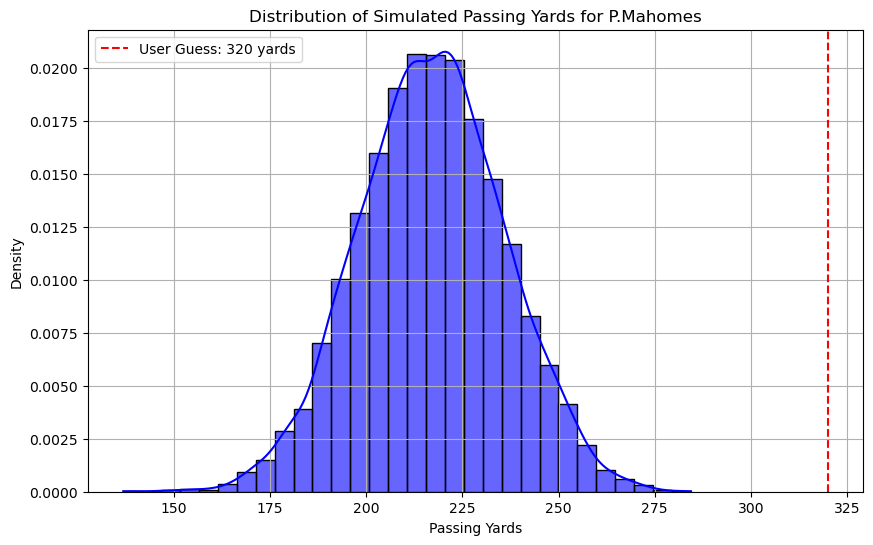

In [155]:
def plot_qb_simulation_curve(qb_name, simulated_df, user_guess=None):
    """
    Plots the distribution (curve) of simulated passing yards for a given QB.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param simulated_df: DataFrame containing simulated passing yards for each QB.
    :param user_guess: Optional user guess for passing yards to plot on the curve.
    """
    # Ensure the QB name is in the simulated results
    if qb_name not in simulated_df.columns:
        raise ValueError(f"Quarterback {qb_name} not found in the simulation results.")
    
    # Get the simulated passing yards for the specified QB
    qb_simulations = simulated_df[qb_name]
    
    # Plot the distribution of the simulated passing yards
    plt.figure(figsize=(10, 6))
    sns.histplot(qb_simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
    # Add the user guess line if provided
    if user_guess is not None:
        plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
    
    plt.title(f"Distribution of Simulated Passing Yards for {qb_name}")
    plt.xlabel("Passing Yards")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
if __name__ == "__main__":
    qb_name = "P.Mahomes"  # Example quarterback name
    user_guess = 320  # Example user guess for passing yards (optional)
    
    # Plot the curve for Patrick Mahomes with the user guess line
    plot_qb_simulation_curve(qb_name, simulated_df, user_guess=user_guess)